In [115]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

import pickle
from joblib import dump
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [3]:


query = """
    select *
       from eigensonne_dwh.public.lead_scoring_sample_1 """
    
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,has_been_wfp,time_since_last_db_activity
0,00Q5J000003aamPUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,1,14
1,00Q5J000003bpmLUAQ,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,0,0,0
2,00Q5J000003bzR2UAI,Website,nativead,Baden-Württemberg,Rent,1,0,1,1,0
3,00Q5J000003bZwOUAU,Wattfox,affiliate,Baden-Württemberg,Rent,1,0,0,1,12
4,00Q5J0000041o74UAA,Wattfox,affiliate,Baden-Württemberg,Rent,1,1,0,0,3


In [4]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [5]:
print(base.shape)
base.dtypes

(21700, 10)


id                             object
lead_source                    object
lead_medium                    object
bundesland                     object
record_type_name_c             object
has_opened                      int64
has_clicked_non_photo_url       int64
photo_uploaded                  int64
has_been_wfp                    int64
time_since_last_db_activity     int64
dtype: object

In [6]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21700 entries, 0 to 21699
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           21700 non-null  object
 1   lead_source                  21700 non-null  object
 2   lead_medium                  21700 non-null  object
 3   bundesland                   21700 non-null  object
 4   record_type_name_c           21700 non-null  object
 5   has_opened                   21700 non-null  int64 
 6   has_clicked_non_photo_url    21700 non-null  int64 
 7   photo_uploaded               21700 non-null  int64 
 8   has_been_wfp                 21700 non-null  int64 
 9   time_since_last_db_activity  21700 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [7]:
base.describe()

,has_opened,has_clicked_non_photo_url,photo_uploaded,has_been_wfp,time_since_last_db_activity
count,21700.000000,21700.000000,21700.000000,21700.000000,21700.000000
mean,0.714194,0.102074,0.184194,0.358710,6.405069
std,0.451808,0.302752,0.387651,0.479633,9.260916
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,0.000000,1.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,127.000000


In [10]:
data = base.copy(deep=True)

In [11]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       21700
unique          8
top       Wattfox
freq         7021
Name: lead_source, dtype: object

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

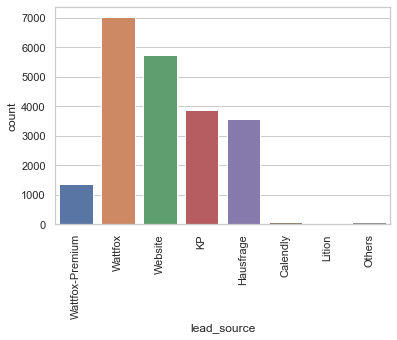

In [12]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [13]:
data.groupby(['lead_source'])['id'].count()

lead_source
Calendly             77
Hausfrage          3567
KP                 3873
Lition               40
Others               58
Wattfox            7021
Wattfox-Premium    1345
Website            5719
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

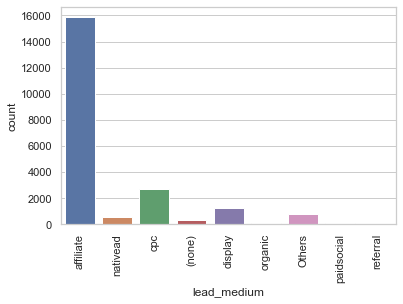

In [14]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [15]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)          344
Others          763
affiliate     15868
cpc            2695
display        1275
nativead        532
organic         116
paidsocial       63
referral         44
Name: id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

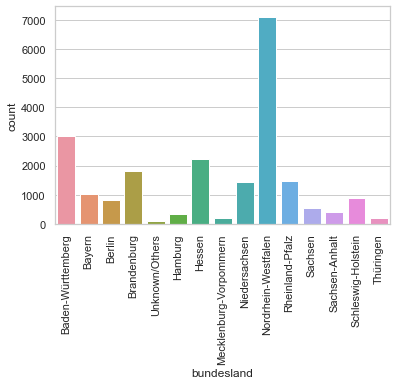

In [16]:
sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [17]:
data.groupby(['bundesland'])['id'].count()

bundesland
Baden-Württemberg         3032
Bayern                    1033
Berlin                     809
Brandenburg               1822
Hamburg                    346
Hessen                    2239
Mecklenburg-Vorpommern     197
Niedersachsen             1445
Nordrhein-Westfalen       7116
Rheinland-Pfalz           1473
Sachsen                    552
Sachsen-Anhalt             422
Schleswig-Holstein         903
Thüringen                  214
Unknown/Others              97
Name: id, dtype: int64

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text major ticklabel objects>)

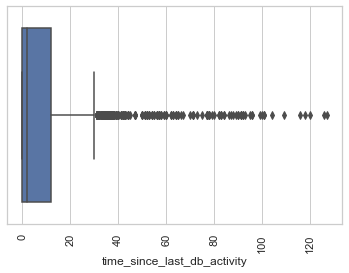

In [19]:
plt1 = sns.boxplot(data['time_since_last_db_activity'])
xticks(rotation = 90)

<ipython-input-20-703fe8d55db9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_since_last_db_activity'][data['time_since_last_db_activity'] <= percentiles[0]] = percentiles[0]


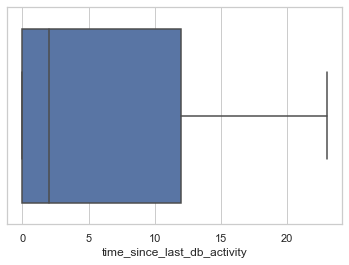

In [20]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['time_since_last_db_activity'].quantile([0.00,0.95]).values
data['time_since_last_db_activity'][data['time_since_last_db_activity'] <= percentiles[0]] = percentiles[0]
data['time_since_last_db_activity'][data['time_since_last_db_activity'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['time_since_last_db_activity'])

In [21]:
data['time_since_last_db_activity'].median()

2.0

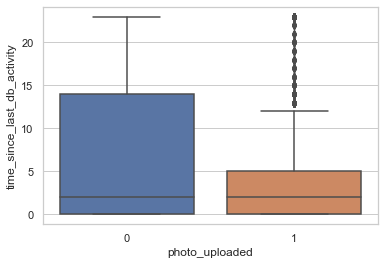

In [22]:
sns.boxplot(y = 'time_since_last_db_activity', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is different

In [23]:
data['record_type_name_c'].describe()


count       21700
unique          2
top       Regular
freq        16102
Name: record_type_name_c, dtype: object

In [24]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                             0.0
lead_source                    0.0
lead_medium                    0.0
bundesland                     0.0
record_type_name_c             0.0
has_opened                     0.0
has_clicked_non_photo_url      0.0
photo_uploaded                 0.0
has_been_wfp                   0.0
time_since_last_db_activity    0.0
dtype: float64

In [25]:
#Exploratory Data Analytics
# Univariate Analysis 

In [26]:
Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

18.41935483870968

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

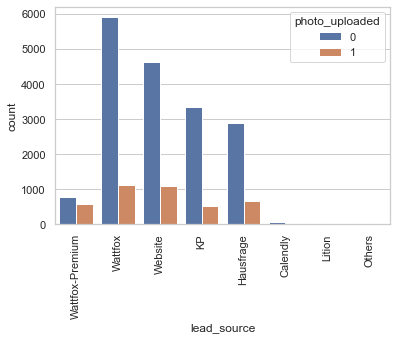

In [27]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

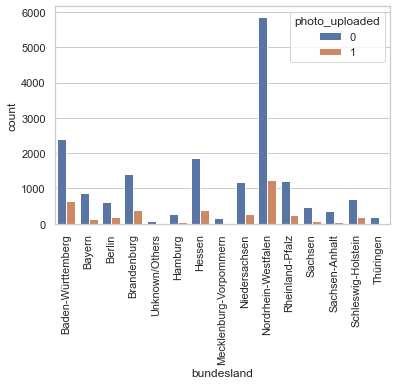

In [28]:
#lead_source 
sns.countplot(x = "bundesland", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

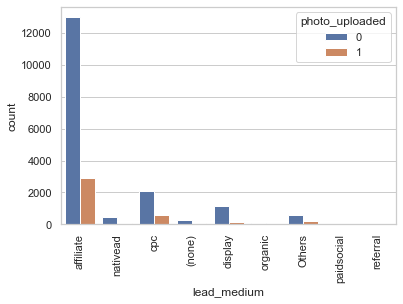

In [29]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

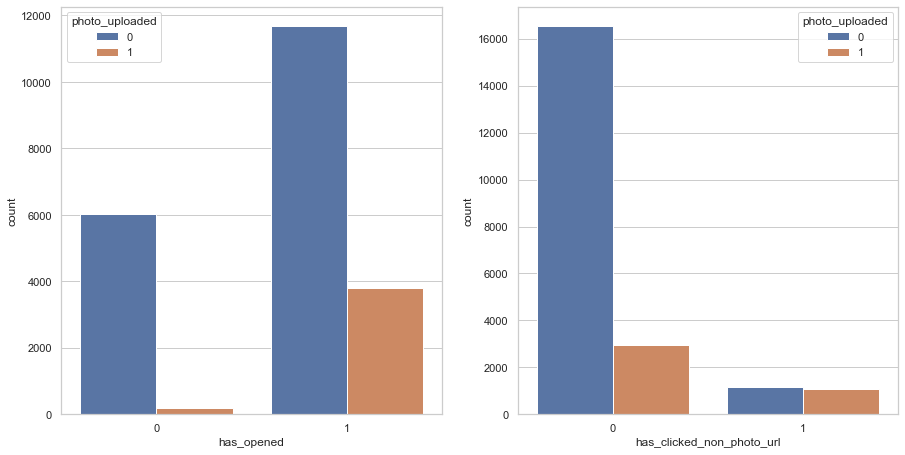

In [30]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_uploaded", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_uploaded", data = data, ax = axs[1])

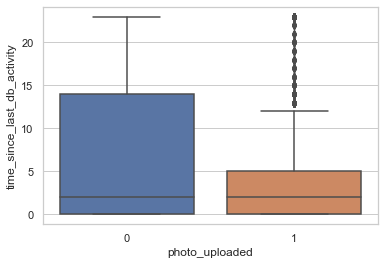

In [32]:
sns.boxplot(y = 'time_since_last_db_activity', x = 'photo_uploaded', data = data)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

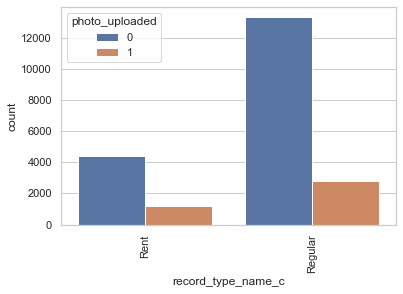

In [33]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

In [34]:
d = data.corr()
m = ((d>0.5)&(d!=1))|((d<-0.5)&(d!=-1))
d[m].stack().drop_duplicates().round(3).to_dict()

{('photo_uploaded', 'has_been_wfp'): 0.629}

In [35]:
data.head(10)

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,has_been_wfp,time_since_last_db_activity
0,00Q5J000003aamPUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,1,14
1,00Q5J000003bpmLUAQ,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,0,0,0
2,00Q5J000003bzR2UAI,Website,nativead,Baden-Württemberg,Rent,1,0,1,1,0
3,00Q5J000003bZwOUAU,Wattfox,affiliate,Baden-Württemberg,Rent,1,0,0,1,12
4,00Q5J0000041o74UAA,Wattfox,affiliate,Baden-Württemberg,Rent,1,1,0,0,3
5,00Q5J000003YyjVUAS,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,1,14
6,00Q5J000003asToUAI,KP,affiliate,Baden-Württemberg,Rent,1,1,1,1,20
7,00Q5J000003aJPuUAM,Hausfrage,affiliate,Baden-Württemberg,Rent,1,0,0,0,0
8,00Q5J000003bdmfUAA,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,0,0
9,00Q5J000003YyjQUAS,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,0,0,22


In [234]:
# Data Preparation



In [36]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source',# 'radius_category',
                           'lead_medium','bundesland'
                             ]], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003aamPUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,1,14,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00Q5J000003bpmLUAQ,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000003bzR2UAI,Website,nativead,Baden-Württemberg,Rent,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003bZwOUAU,Wattfox,affiliate,Baden-Württemberg,Rent,1,0,0,1,12,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J0000041o74UAA,Wattfox,affiliate,Baden-Württemberg,Rent,1,1,0,0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',#'radius_category',
                             'record_type_name_c'], axis = 1)


In [39]:
data.head(10)

,id,has_opened,has_clicked_non_photo_url,photo_uploaded,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003aamPUAQ,1,1,0,1,14,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00Q5J000003bpmLUAQ,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000003bzR2UAI,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003bZwOUAU,1,0,0,1,12,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J0000041o74UAA,1,1,0,0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,00Q5J000003YyjVUAS,1,0,0,1,14,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000003asToUAI,1,1,1,1,20,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,00Q5J000003aJPuUAM,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00Q5J000003bdmfUAA,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,00Q5J000003YyjQUAS,0,0,0,0,22,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_uploaded'], axis=1)
X.head()

,has_opened,has_clicked_non_photo_url,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,1,1,14,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,12,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
y = data['photo_uploaded']

y.head()

0    0
1    0
2    1
3    0
4    0
Name: photo_uploaded, dtype: int64

In [42]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.3, random_state=None)

In [43]:
X_train.head()

,has_opened,has_clicked_non_photo_url,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
19396,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2862,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9685,0,0,0,23,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3438,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
13566,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [44]:
#feature scaling
scaler = StandardScaler()


X_train[['time_since_last_db_activity']] = scaler.fit_transform(
    X_train[['time_since_last_db_activity']])

#X_train[['distance']] = scaler.fit_transform(
#    X_train[['distance']])

X_train.head()

<ipython-input-44-2bf3568c6010>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['time_since_last_db_activity']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
19396,1,0,0,-0.818556,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2862,1,0,0,-0.818556,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9685,0,0,0,2.398816,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3438,0,0,0,-0.818556,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
13566,1,0,1,-0.818556,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [45]:
#How many conversions do we have 

Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

18.41935483870968

In [46]:
#Model building 

In [122]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1_fit=logm1.fit()
logm1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                15189
Model:                            GLM   Df Residuals:                    15154
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2020.7
Date:                Tue, 16 Feb 2021   Deviance:                       4041.4
Time:                        20:27:49   Pearson chi2:                 8.76e+06
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -9.3587      1.119     -8.365      0.000     -11.551      -7.166
has_opened                            1.6545      0.155     10.682      0.000       1.351       1.958
has_clicked_non_photo_url             0.9706      0.108      8.994      0.000       0.759       1.182
has_been_wfp                          8.2593      0.246     33.507      0.000       7.776       8.742
time_since_last_db_activity          -2.4416      0.058    -41.883      0.000      -2.556      -2.327
record_type_name_c_Rent              -0.0304      0.093     -0.328      0.743      -0.212       0.151
lead_source_Hausfrage                 3.8044      2.767      1.375      0.169      -1.618       9.227
lead_source_KP                        3.9674      2.768      1.433      0.152      -1.457       9.392
lead_source_Lition                    4.6702      2.940      1.588      0.112      -1.092      10.433
lead_source_Others                    4.5317      1.355      3.345      0.001       1.877       7.187
lead_source_Wattfox                   4.0986      2.766      1.482      0.138      -1.323       9.521
lead_source_Wattfox-Premium           3.9223      2.767      1.417      0.156      -1.502       9.346
lead_source_Website                   0.5625      1.001      0.562      0.574      -1.400       2.525
lead_medium_Others                    0.2648      0.485      0.546      0.585      -0.686       1.215
lead_medium_affiliate                -3.5713      2.621     -1.362      0.173      -8.709       1.566
lead_medium_cpc                       0.2282      0.437      0.522      0.602      -0.629       1.085
lead_medium_display                  -0.1921      0.472     -0.407      0.684      -1.118       0.733
lead_medium_nativead                 -0.0961      0.521     -0.185      0.854      -1.117       0.924
lead_medium_organic                   0.4309      0.765      0.563      0.573      -1.068       1.930
lead_medium_paidsocial                0.0730      0.852      0.086      0.932      -1.598       1.744
lead_medium_referral                 -1.8210      1.104     -1.650      0.099      -3.985       0.343
bundesland_Bayern                    -0.2160      0.225     -0.962      0.336      -0.656       0.224
bundesland_Berlin                     0.0805      0.237      0.339      0.734      -0.385       0.546
bundesland_Brandenburg               -0.2008      0.169     -1.190      0.234      -0.532       0.130
bundesland_Hamburg                    0.2582      0.372      0.694      0.487      -0.470       0.987
bundesland_Hessen                    -0.3167      0.167     -1.900      0.057      -0.643       0.010
bundesland_Mecklenburg-Vorpommern    -0.9914      0.591     -1.678      0.093      -2.149       0.167
bundesland_Niedersachse

In [52]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 12)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([ True,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True, False, False,  True])

In [53]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('has_been_wfp', True, 1),
 ('time_since_last_db_activity', True, 1),
 ('record_type_name_c_Rent', False, 21),
 ('lead_source_Hausfrage', False, 5),
 ('lead_source_KP', False, 16),
 ('lead_source_Lition', False, 2),
 ('lead_source_Others', True, 1),
 ('lead_source_Wattfox', False, 23),
 ('lead_source_Wattfox-Premium', False, 15),
 ('lead_source_Website', False, 4),
 ('lead_medium_Others', True, 1),
 ('lead_medium_affiliate', False, 3),
 ('lead_medium_cpc', True, 1),
 ('lead_medium_display', False, 12),
 ('lead_medium_nativead', False, 17),
 ('lead_medium_organic', True, 1),
 ('lead_medium_paidsocial', False, 19),
 ('lead_medium_referral', False, 13),
 ('bundesland_Bayern', False, 10),
 ('bundesland_Berlin', False, 18),
 ('bundesland_Brandenburg', False, 11),
 ('bundesland_Hamburg', True, 1),
 ('bundesland_Hessen', False, 6),
 ('bundesland_Mecklenburg-Vorpommern', True, 1),
 ('bundesland_Niedersachsen', False, 9),
 ('bu

In [54]:
col = X_train.columns[rfe.support_]

# this is me just taking out the ones that are > 0.1
#col =X_train.columns[([ True,  True, True,  True, True, True, 
#                       False,  False,  False, True,  False,  False,
#                       True,  True, True,  False,  True, True,
#                        False,  True, False, True, False, False, 
#                       False,  False, True, False, True,  False,
#                       False, True, False, False,  False])]
col

Index(['has_opened', 'has_clicked_non_photo_url', 'has_been_wfp',
       'time_since_last_db_activity', 'lead_source_Others',
       'lead_medium_Others', 'lead_medium_cpc', 'lead_medium_organic',
       'bundesland_Hamburg', 'bundesland_Mecklenburg-Vorpommern',
       'bundesland_Sachsen-Anhalt', 'bundesland_Unknown/Others'],
      dtype='object')

In [55]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                15189
Model:                            GLM   Df Residuals:                    15176
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2030.4
Date:                Tue, 16 Feb 2021   Deviance:                       4060.7
Time:                        16:43:37   Pearson chi2:                 8.70e+06
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -9.1026      0.279    -32.672      0.000      -9.649      -8.557
has_opened                            1.6394      0.154     10.649      0.000       1.338       1.941
has_clicked_non_photo_url             0.9624      0.107      8.966      0.000       0.752       1.173
has_been_wfp                          8.2221      0.245     33.526      0.000       7.741       8.703
time_since_last_db_activity          -2.4363      0.058    -42.101      0.000      -2.550      -2.323
lead_source_Others                    2.7652      0.891      3.105      0.002       1.020       4.511
lead_medium_Others                    0.4590      0.247      1.860      0.063      -0.025       0.943
lead_medium_cpc                       0.4013      0.137      2.931      0.003       0.133       0.670
lead_medium_organic                   0.6201      0.641      0.967      0.334      -0.637       1.877
bundesland_Hamburg                    0.4597      0.356      1.291      0.197      -0.238       1.158
bundesland_Mecklenburg-Vorpommern    -0.8464      0.581     -1.457      0.145      -1.985       0.292
bundesland_Sachsen-Anhalt            -0.4465      0.320     -1.396      0.163      -1.073       0.180
bundesland_Unknown/Others             2.0990      0.751      2.796      0.005       0.628       3.570
=====================================================================================================
"""

In [123]:
#col2 = col.drop(['lead_medium_nativead', 'lead_source_Hausfrage',
#                  'bundesland_Berlin','bundesland_Niedersachsen','bundesland_Rheinland-Pfalz',
#                'bundesland_Sachsen-Anhalt'],1)
#X_train_sm = sm.add_constant(X_train[col2])
#logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
#res = logm2.fit()
#res.summary()

In [56]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

19396    6.257808e-03
2862     7.776477e-03
9685     4.818462e-07
3438     8.175870e-04
13566    9.400887e-01
11915    5.816006e-04
20705    8.494994e-01
18961    1.656313e-01
17619    8.635039e-02
21491    8.175870e-04
dtype: float64

In [57]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.25780776e-03, 7.77647723e-03, 4.81846245e-07, 8.17586957e-04,
       9.40088666e-01, 5.81600582e-04, 8.49499381e-01, 1.65631321e-01,
       8.63503855e-02, 8.17586957e-04])

In [58]:
#
y_train_pred_final = pd.DataFrame({'photo_uploaded':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id
0,0,6.257808e-03,19396
1,0,7.776477e-03,2862
2,0,4.818462e-07,9685
3,0,8.175870e-04,3438
4,1,9.400887e-01,13566


In [59]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted
0,0,6.257808e-03,19396,0
1,0,7.776477e-03,2862,0
2,0,4.818462e-07,9685,0
3,0,8.175870e-04,3438,0
4,1,9.400887e-01,13566,1


In [60]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
print(confusion)


[[12037   343]
 [  300  2509]]


In [61]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted))

0.9576667325037856


In [62]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
0,has_opened,1.87
2,has_been_wfp,1.83
1,has_clicked_non_photo_url,1.24
6,lead_medium_cpc,1.13
3,time_since_last_db_activity,1.08
5,lead_medium_Others,1.05
4,lead_source_Others,1.03
11,bundesland_Unknown/Others,1.03
7,lead_medium_organic,1.01
8,bundesland_Hamburg,1.01


In [63]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [64]:
TN

12037

In [65]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8932004271982912

In [66]:
# Let us calculate specificity
TN / float(TN+FP)

0.9722940226171244

In [67]:
# positive predictive value 
print (TP / float(TP+FP))

0.8797335203366059


In [68]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9756829050822728


In [69]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

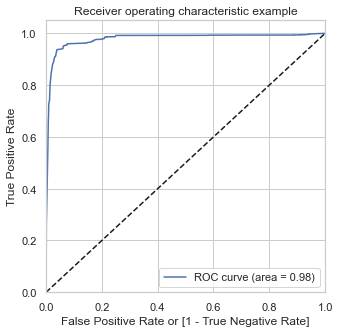

In [70]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_uploaded, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

In [71]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,6.257808e-03,19396,0,1,0,0,0,0,0,0,0,0,0
1,0,7.776477e-03,2862,0,1,0,0,0,0,0,0,0,0,0
2,0,4.818462e-07,9685,0,1,0,0,0,0,0,0,0,0,0
3,0,8.175870e-04,3438,0,1,0,0,0,0,0,0,0,0,0
4,1,9.400887e-01,13566,1,1,1,1,1,1,1,1,1,1,1


In [72]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.184936  1.000000  0.000000
0.1   0.1  0.873988  0.963688  0.853635
0.2   0.2  0.940812  0.950160  0.938691
0.3   0.3  0.956548  0.925240  0.963651
0.4   0.4  0.957733  0.909220  0.968740
0.5   0.5  0.957667  0.893200  0.972294
0.6   0.6  0.956548  0.845141  0.981826
0.7   0.7  0.950820  0.795657  0.986026
0.8   0.8  0.940088  0.717693  0.990549
0.9   0.9  0.908947  0.534354  0.993942


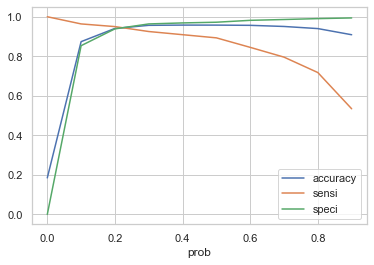

In [73]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [74]:
#### From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,6.257808e-03,19396,0,1,0,0,0,0,0,0,0,0,0,0
1,0,7.776477e-03,2862,0,1,0,0,0,0,0,0,0,0,0,0
2,0,4.818462e-07,9685,0,1,0,0,0,0,0,0,0,0,0,0
3,0,8.175870e-04,3438,0,1,0,0,0,0,0,0,0,0,0,0
4,1,9.400887e-01,13566,1,1,1,1,1,1,1,1,1,1,1,1


In [75]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,6.257808e-03,19396,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,7.776477e-03,2862,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,4.818462e-07,9685,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,8.175870e-04,3438,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,9.400887e-01,13566,1,1,1,1,1,1,1,1,1,1,1,1,94


In [76]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9501601993592026

In [77]:
# Let us calculate specificity
TN / float(TN+FP)

0.9386914378029079

In [78]:
# Calculate false postive rate - predicting photo when customer did not send photo
print(FP/ float(TN+FP))

0.06130856219709208


In [79]:
# Positive predictive value 
print (TP / float(TP+FP))

0.7785880980163361


In [80]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9880962503188504


In [81]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
confusion

array([[12037,   343],
       [  300,  2509]])

In [82]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8797335203366059

In [83]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.8932004271982912

In [84]:
y_train_pred_final.photo_uploaded, y_train_pred_final.predicted

(0        0
 1        0
 2        0
 3        0
 4        1
         ..
 15184    0
 15185    0
 15186    0
 15187    0
 15188    1
 Name: photo_uploaded, Length: 15189, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        1
         ..
 15184    0
 15185    0
 15186    0
 15187    0
 15188    1
 Name: predicted, Length: 15189, dtype: int64)

In [85]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

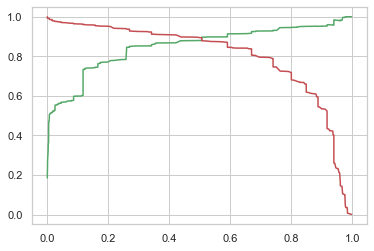

In [86]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [87]:
#Making predictions on the test set

X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])

X_train.head()

<ipython-input-87-c944f2535866>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,has_been_wfp,time_since_last_db_activity,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
19396,1,0,0,-0.818556,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2862,1,0,0,-0.818556,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9685,0,0,0,2.398816,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3438,0,0,0,-0.818556,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
13566,1,0,1,-0.818556,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [88]:
X_test = X_test[col]
X_test.head()

,has_opened,has_clicked_non_photo_url,has_been_wfp,time_since_last_db_activity,lead_source_Others,lead_medium_Others,lead_medium_cpc,lead_medium_organic,bundesland_Hamburg,bundesland_Mecklenburg-Vorpommern,bundesland_Sachsen-Anhalt,bundesland_Unknown/Others
11072,1,0,0,2.372891,0,0,0,0,0,0,0,0
12442,1,0,0,-0.821242,0,0,0,0,0,0,0,0
13078,1,0,1,1.123013,0,0,0,0,0,0,0,0
548,1,1,1,0.706387,0,0,0,0,0,0,0,0
2415,1,0,0,-0.821242,0,0,0,0,0,0,0,0


In [89]:
X_test_sm = sm.add_constant(X_test)

In [90]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


11072    0.000002
12442    0.004225
13078    0.121616
548      0.500053
2415     0.004225
4363     0.000587
7135     0.000055
6512     0.851272
10197    0.004225
7158     0.002152
dtype: float64

In [91]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
11072,0.000002
12442,0.004225
13078,0.121616
548,0.500053
2415,0.004225


In [92]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_uploaded,id,0
0,1,11072,0.000002
1,0,12442,0.004225
2,0,13078,0.121616
3,1,548,0.500053
4,0,2415,0.004225


In [93]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob
0,1,11072,0.000002
1,0,12442,0.004225
2,0,13078,0.121616
3,1,548,0.500053
4,0,2415,0.004225


In [94]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob,final_predicted
0,1,11072,0.000002,0
1,0,12442,0.004225,0
2,0,13078,0.121616,0
3,1,548,0.500053,1
4,0,2415,0.004225,0


In [95]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_uploaded, y_pred_final.final_predicted)

0.9420890937019969

In [96]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_uploaded, y_pred_final.final_predicted )
confusion2

array([[5005,  318],
       [  59, 1128]])

In [97]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [98]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9502948609941028

In [99]:
# Let us calculate specificity
TN / float(TN+FP)

0.9402592523013338

In [100]:
y_pred_final['Lead_Score'] = y_pred_final.photo_upload_prob.map( lambda x: round(x*100))

In [101]:
print(y_pred_final.shape)
y_pred_final.head()

(6510, 5)


,photo_uploaded,id,photo_upload_prob,final_predicted,Lead_Score
0,1,11072,0.000002,0,0
1,0,12442,0.004225,0,0
2,0,13078,0.121616,0,12
3,1,548,0.500053,1,50
4,0,2415,0.004225,0,0


In [102]:
y_train_pred_final=y_train_pred_final.drop(['predicted',0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],1)
print(y_train_pred_final.shape)
y_train_pred_final.head()

(15189, 5)


,photo_uploaded,photo_upload_prob,id,final_predicted,Lead_Score
0,0,6.257808e-03,19396,0,1
1,0,7.776477e-03,2862,0,1
2,0,4.818462e-07,9685,0,0
3,0,8.175870e-04,3438,0,0
4,1,9.400887e-01,13566,1,94


In [103]:
y_pred_final=y_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]
y_train_pred_final=y_train_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]

In [104]:
y_pred_final.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,11072,1,0.000002,0,0
1,12442,0,0.004225,0,0
2,13078,0,0.121616,0,12
3,548,1,0.500053,1,50
4,2415,0,0.004225,0,0


In [105]:
pred_values=pd.concat([y_train_pred_final,y_pred_final]).reset_index(drop=True)
pred_values.shape

(21699, 5)

In [106]:
pred_values.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,19396,0,6.257808e-03,0,1
1,2862,0,7.776477e-03,0,1
2,9685,0,4.818462e-07,0,0
3,3438,0,8.175870e-04,0,0
4,13566,1,9.400887e-01,1,94


In [107]:
Final= base.merge(pred_values, how='left',left_index=True,right_on='id', suffixes=('_left', '_right')).reset_index(drop=True)
Final.shape

(21700, 16)

In [108]:
Final.loc[Final.photo_uploaded_left != Final.photo_uploaded_right]

,id,id_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded_left,has_been_wfp,time_since_last_db_activity,id_right,photo_uploaded_right,photo_upload_prob,final_predicted,Lead_Score
19259,19259,00Q5J000003Y9zTUAS,Wattfox,affiliate,Rheinland-Pfalz,Regular,1,0,1,1,3,NaN,NaN,NaN,NaN,NaN


In [109]:
Final=Final[['id_left','Lead_Score','photo_uploaded_left','lead_source','lead_medium','bundesland',#'radius_category','distance',
             'record_type_name_c','has_opened',	'has_clicked_non_photo_url',
             'time_since_last_db_activity']]
Final.head(50)

,id_left,Lead_Score,photo_uploaded_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,time_since_last_db_activity
0,00Q5J000003aamPUAQ,27.0,0,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,14
1,00Q5J000003bpmLUAQ,0.0,0,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,0
2,00Q5J000003bzR2UAI,94.0,1,Website,nativead,Baden-Württemberg,Rent,1,0,0
3,00Q5J000003bZwOUAU,21.0,0,Wattfox,affiliate,Baden-Württemberg,Rent,1,0,12
4,00Q5J0000041o74UAA,0.0,0,Wattfox,affiliate,Baden-Württemberg,Rent,1,1,3
5,00Q5J000003YyjVUAS,12.0,0,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,14
6,00Q5J000003asToUAI,4.0,1,KP,affiliate,Baden-Württemberg,Rent,1,1,20
7,00Q5J000003aJPuUAM,0.0,0,Hausfrage,affiliate,Baden-Württemberg,Rent,1,0,0
8,00Q5J000003bdmfUAA,0.0,0,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0
9,00Q5J000003YyjQUAS,0.0,0,Wattfox,affiliate,Baden-Württemberg,Regular,0,0,22


In [110]:
#res = logm2.fit()
res

In [113]:
# save using pickle
data = pickle.dumps(res)
loaded_model = pickle.loads(data)
result = loaded_model.predict(X_test_sm)
result

11072    0.000002
12442    0.004225
13078    0.121616
548      0.500053
2415     0.004225
           ...   
5469     0.006546
11697    0.000587
7030     0.002429
9882     0.596576
16495    0.006299
Length: 6510, dtype: float64

In [116]:
# save file using joblib
joblib.dump(res, 'trained_model.pkl') 
clf_from_joblib = joblib.load('trained_model.pkl') 
result= clf_from_joblib.predict(X_test_sm)
result

11072    0.000002
12442    0.004225
13078    0.121616
548      0.500053
2415     0.004225
           ...   
5469     0.006546
11697    0.000587
7030     0.002429
9882     0.596576
16495    0.006299
Length: 6510, dtype: float64

In [331]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")

sql = "INSERT INTO eigensonne_dwh.public.fit_model VALUES(%s)"
cr = conn.cursor()
cr.execute(sql, (psycopg2.Binary(data),) )
conn.commit() 
cr.close()

In [117]:
res.params

const                               -9.102617
has_opened                           1.639374
has_clicked_non_photo_url            0.962384
has_been_wfp                         8.222070
time_since_last_db_activity         -2.436342
lead_source_Others                   2.765167
lead_medium_Others                   0.458954
lead_medium_cpc                      0.401313
lead_medium_organic                  0.620116
bundesland_Hamburg                   0.459669
bundesland_Mecklenburg-Vorpommern   -0.846388
bundesland_Sachsen-Anhalt           -0.446527
bundesland_Unknown/Others            2.098972
dtype: float64